# The instagram comment scraper

## The inspiration
My friend *kwokho* participated in an instagram competition by GOMObysingtel. The challenge was to get as many comments tagged to his number (2). However, we started observing many suspicious accounts with 10 or less followers/following commenting for number 4, another participant. 

This got me curious about how GOMO would actually count the number of comments and I wanted to find out if I was able to actually sieve through the comments to see who is considered a bot or not. SO LETS TRY THIS OUT.

## The plan
tldr: scrape comments, link user to commented number, verify user (botOrNot)

I did a quick google search on existing instagram apis out there and tried a few. The one that worked best in my short testing was [instagrapi](https://adw0rd.github.io/instagrapi/). It allowed me to obtain data using a public API (web, anon) or a private API (mobile app, authorized) depending on my use case. It has the potential to do lots of things like posting comments and liking stuff (what if this is actually what the bots are using hmm). In any case, I just needed to extract that comment data and play with it.

// side note: it's current 4am, 24th March 2023 and I have other work to do but this seemed more fun so here I am

// edit: my instagram account got blocked for probably making too many calls to get the comments... in the process of unblocking, I needed to take a selfie to prove I'm not a bot omg


### Step 1: Getting the comments

In [168]:
from instagrapi import Client
import pickle
from math import inf as Inf

### GETTING THAT DATA

cl = Client()

# As you'll see I'm using the private API in this case
USERNAME = "REDACTED";
PASSWORD = "REDACTED";
cl.login(USERNAME, PASSWORD) 
media_id = cl.media_id(cl.media_pk_from_url('https://www.instagram.com/p/CqCwTHCJpnH/'))
# edit: I realised that I was only getting the first 20 comments, oh I gotta change the 2nd argument to a larger number
comments = cl.media_comments(media_id, 999)

with open('comments.pkl', 'wb') as f:
    pickle.dump(comments, f)

Status 429: Too many requests
Ignore 429: Continue login


### Step 2: Cleaning the Dataset

In [199]:
with open('comments.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

# Convert to pandas dataframe for easy manipulation
import pandas as pd 
df = pd.DataFrame(loaded_dict)
print("number of rows:", df.shape[0])


# Just gonna do some cleanup
first_row = df.iloc[0].to_list()
column_names = {}
for i, name in enumerate(df.columns):
    column_names[name] = first_row[i][0]
    
# Renamed the column headers to their actual meanings
df = df.rename(columns=column_names)

# Remove the headers in each data cell
for i, row in df.iterrows():
    for col in df.columns:
        df.at[i, col] = row[col][1]

# Couldn't find documentation on UserShort class, so I printed the methods and found username!
print(dir(df.at[1, 'user']))

# Special edit to convert user > username
for i, row in df.iterrows():
    placeholder = row['user']
    df.at[i, 'user'] = placeholder.username
    df.at[i, 'user_id'] = placeholder.pk
df = df.rename(columns={'user': 'username'})
# print(df.head())

# I just need the text, username and timestamp
new_df = df.loc[:, ['text', 'username', 'created_at_utc']]
new_df

number of rows: 987
['Config', '__abstractmethods__', '__annotations__', '__class__', '__class_vars__', '__config__', '__custom_root_type__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__exclude_fields__', '__fields__', '__fields_set__', '__format__', '__ge__', '__get_validators__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__include_fields__', '__init__', '__init_subclass__', '__iter__', '__json_encoder__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__post_root_validators__', '__pre_root_validators__', '__pretty__', '__private_attributes__', '__reduce__', '__reduce_ex__', '__repr__', '__repr_args__', '__repr_name__', '__repr_str__', '__rich_repr__', '__schema_cache__', '__setattr__', '__setstate__', '__signature__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__try_update_forward_refs__', '__validators__', '_abc_impl', '_calculate_keys', '_copy_and_set_values', '_decompose_class', '_enforce_dict_if_root', '_get_value', '_in

,text,username,created_at_utc
0,4 definitely!,deewee.09,2023-03-24 15:12:05+00:00
1,1,md.forhadrabid,2023-03-24 15:08:50+00:00
2,1🔥!,dfra08,2023-03-24 15:05:06+00:00
3,Yess number 4,maksim_lopatev,2023-03-24 14:49:55+00:00
4,2,wanyeeeeet,2023-03-24 14:33:53+00:00
...,...,...,...
982,4,weix3n,2023-03-21 08:56:11+00:00
983,4!,woshixida,2023-03-21 08:20:20+00:00
984,4!!!,jessagan,2023-03-21 08:07:07+00:00
985,4!,cheowhonnggg,2023-03-21 08:06:52+00:00


### Step 3: Refining the comments
too many words... let's just narrow it down to the person (or number) they're supporting.
I'm just gonna do this primitively since I just want a quick result for now.

Long comments (>200 characters) -> will not be counted

Short comments -> counted

In [171]:
new_df = df.loc[:, ['text', 'username', 'created_at_utc']]
clean_df = new_df.copy()
valid_inputs = ('1', '2', '3', '4')
print(len(new_df.loc[6, 'text']))
# iterate through the rows and reduce text to a number
# and finding numbers in the text
import re

for i, row in clean_df.iterrows():
    if len(clean_df.loc[i, 'text']) > 200:
        clean_df.drop(i, inplace=True)
        new_df.drop(i, inplace=True)
    else:
        clean_df.at[i, 'text'] = re.findall(r'\d+',clean_df.loc[i, 'text'])
        
for i, row in clean_df.iterrows():
    # if comment has more than one number, invalid
    if len(clean_df.loc[i, 'text']) > 1:
        clean_df.drop(i, inplace=True)
        
    # remove rows with no numbers
    elif len(clean_df.loc[i, 'text']) == 0:
        clean_df.drop(i, inplace=True)
    
    # remove invalid numbers
    elif clean_df.loc[i, 'text'][0] not in valid_inputs:
        print(clean_df.loc[i, 'text'])
        clean_df.drop(i, inplace=True)
        

    

# okay good enough
clean_df


4
['303']
['303']
['196']
['639']
['11']
['33333333']


,text,username,created_at_utc
0,[4],deewee.09,2023-03-24 15:12:05+00:00
1,[1],md.forhadrabid,2023-03-24 15:08:50+00:00
2,[1],dfra08,2023-03-24 15:05:06+00:00
3,[4],maksim_lopatev,2023-03-24 14:49:55+00:00
4,[2],wanyeeeeet,2023-03-24 14:33:53+00:00
...,...,...,...
982,[4],weix3n,2023-03-21 08:56:11+00:00
983,[4],woshixida,2023-03-21 08:20:20+00:00
984,[4],jessagan,2023-03-21 08:07:07+00:00
985,[4],cheowhonnggg,2023-03-21 08:06:52+00:00


### Step 4: Making it Pretty
Alright let's get to counting

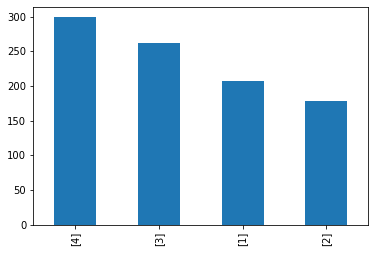

In [172]:
import matplotlib.pyplot as plt

value_counts = clean_df['text'].value_counts()
value_counts.plot(kind='bar')
plt.show()

### Step 5: FIND THE BOTS
SOOooo let's see if we can find who are the bots and who are the bots supporting...
From personal data, I understand they supported 4 a lot, before decided to support everyone and ruining the results so that it wouldn't look obvious, effectively becoming a smear campaign


In [205]:
# Let's return to the original dataframe and see if we can add columns for followers/following
bot_df = df.loc[:, ['text', 'username', 'user_id', 'created_at_utc']]

# for i,row in bot_df.iterrows():
#     bot_df.at[i, 'followers'] = len(cl.user_followers_gql(row['user_id']))
#     bot_df.at[i, 'following'] = len(cl.user_following_gql(row['user_id']))
bot_df


,text,username,user_id,created_at_utc
0,4 definitely!,deewee.09,56317322764,2023-03-24 15:12:05+00:00
1,1,md.forhadrabid,54119311351,2023-03-24 15:08:50+00:00
2,1🔥!,dfra08,207943154,2023-03-24 15:05:06+00:00
3,Yess number 4,maksim_lopatev,44373929300,2023-03-24 14:49:55+00:00
4,2,wanyeeeeet,341169394,2023-03-24 14:33:53+00:00
...,...,...,...,...
982,4,weix3n,225685340,2023-03-21 08:56:11+00:00
983,4!,woshixida,715942701,2023-03-21 08:20:20+00:00
984,4!!!,jessagan,12322994,2023-03-21 08:07:07+00:00
985,4!,cheowhonnggg,334170428,2023-03-21 08:06:52+00:00
